In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import math
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy import exp
from scipy.stats import boxcox
from operator import itemgetter
from sklearn import preprocessing
from numpy.random import randn
import statsmodels.api as sm
import pylab as py

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from sklearn import tree
from sklearn.tree import _tree

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier 

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

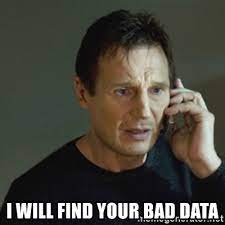

In [ ]:
df = pd.read_csv("../input/home-equity-line-of-credit-data/HMEQ_Loss.csv")

In [ ]:
df.head()

In [ ]:
df.info()

# Checking NAs/Nulls

In [ ]:
df.isna().any()

In [ ]:
df.isnull().sum()

In [ ]:
#Example of counting just one missing column

df['JOB'].isna().sum()

# Impute NULLS

In [ ]:
#Fill Nulls
#df['TARGET_LOSS_AMT'] =df['TARGET_LOSS_AMT'].fillna(0)

#Rest of columns
df['MORTDUE_CLEAN'] =df['MORTDUE'].fillna(value=df['MORTDUE'].mean())
df['VALUE_CLEAN'] =df['VALUE'].fillna(value=df['VALUE'].mean())
df['YOJ_CLEAN'] =df['YOJ'].fillna(value=df['YOJ'].median())
df['DEROG_CLEAN'] =df['DEROG'].fillna(value=df['DEROG'].median())
df['DELINQ_CLEAN'] =df['DELINQ'].fillna(value=df['DELINQ'].median())
df['CLAGE_CLEAN'] =df['CLAGE'].fillna(value=df['CLAGE'].median())
df['NINQ_CLEAN'] =df['NINQ'].fillna(value=df['NINQ'].median())
df['CLNO_CLEAN'] =df['CLNO'].fillna(value=df['CLNO'].median())
df['DEBTINC_CLEAN'] =df['DEBTINC'].fillna(value=df['DEBTINC'].median())
# Clean Text Columns
df['JOB'] = df['JOB'].fillna('Other')
df['REASON'] = df['REASON'].fillna('Other')

In [ ]:
df.isnull().sum()

### Question: Is it better to impute as new columns or clean existing columns?

##### It depends. Normally in production data pipelines, I overwrite. However, in EDA purposes of this demo, I create new column.

# Basic EDA

In [ ]:
df.describe()

In [ ]:
#Create Lists to separate data
numerical = ['LOAN', 'MORTDUE_CLEAN', 'VALUE_CLEAN', 'YOJ_CLEAN', 'DEROG_CLEAN', 'DELINQ_CLEAN', 'CLAGE_CLEAN', 'NINQ_CLEAN'
    ,'DEBTINC_CLEAN']
categorical = ['REASON', 'JOB']

In [ ]:
sns.pairplot(df[numerical], corner=True)

In [ ]:
df[numerical].hist(bins=15, figsize=(15, 10), layout=(3, 4));

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df[numerical].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [ ]:
# Precursor! Remember not all outliers are bad
sns.displot(df, x="LOAN", kind="kde")

In [ ]:
ax = sns.boxplot(x=df["LOAN"])

In [ ]:
sns.displot(df, x="YOJ_CLEAN", kind="kde")

In [ ]:
ax = sns.boxplot(x=df["YOJ_CLEAN"])

In [ ]:
# Skewness is a very powerful tool in the Data Analyst toolbox

"""
Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, 
is symmetric if it looks the same to the left and right of the center point. Kurtosis is a measure of whether 
the data are heavy-tailed or light-tailed relative to a normal distribution.

Good article on math behind it:
https://brownmath.com/stat/shape.htm
"""

print(df["LOAN"].skew())
df["LOAN"].describe()

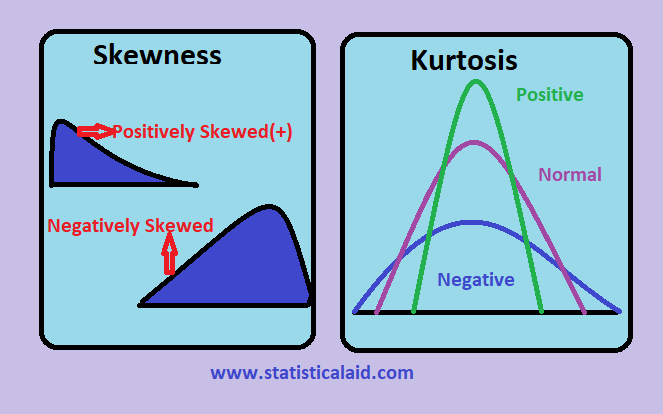

# Duplicate Identification

In [ ]:
# Select duplicate rows except last occurrence based on all columns
duplicateRowsDF = df[df.duplicated(['LOAN', 'VALUE'])]

# Other option, use first or last 
# duplicateRowsDF =  df[df.duplicated(keep='last')]

print("Duplicate Rows except last occurrence based on all columns are :")
print(duplicateRowsDF)

#Sort columns
# df.sort_values(by=['LOAN', 'VALUE'], ascending=False)
#Filter out rows
# df= df.drop_duplicates(subset=['LOAN', 'VALUE'], keep='last').copy()

# Outlier Detection

#### There are two beginner ways to identify outliers: IQR and Z-Score

Great article on box plots:
https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51

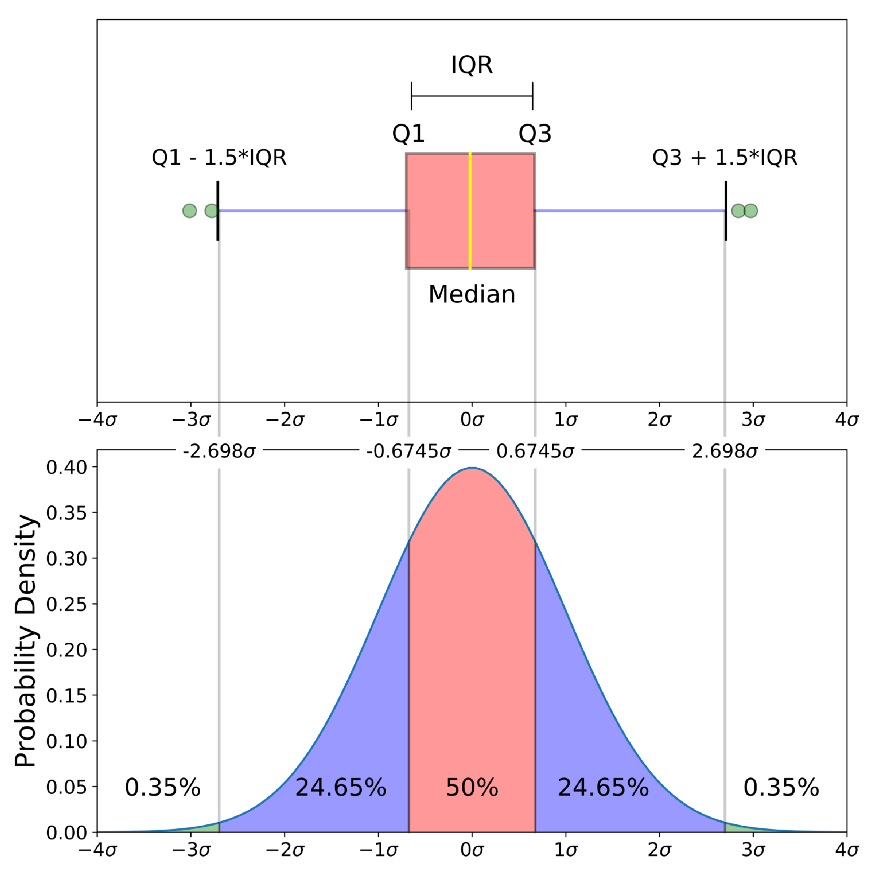

#### We are going to focus on extreme outliers which are defined at 3 * IQR 

# Z Scores

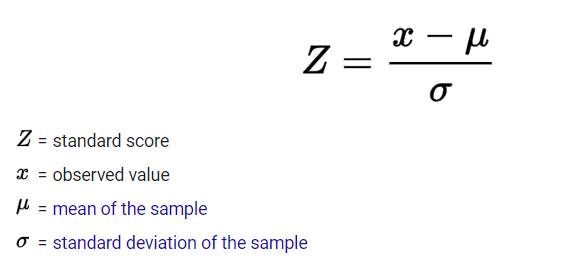

In [ ]:
def outlier_treatment(datacolumn):
    sorted(datacolumn)
    Q1,Q3 = np.percentile(datacolumn , [25,75])
    IQR = Q3 - Q1
    lower_range = Q1 - (3 * IQR)
    upper_range = Q3 + (3 * IQR)
    return lower_range,upper_range



In [ ]:
lower_range,upper_range = outlier_treatment(df.YOJ_CLEAN)
print(lower_range,upper_range)
print('Count how many fit in this IQR:',len(df[(df.YOJ_CLEAN < lower_range) | (df.YOJ_CLEAN > upper_range)]))


In [ ]:
def z_score(datacolumn):
    sorted(datacolumn)
    zscore=stats.zscore(datacolumn)
    return zscore

zscore = z_score(df.YOJ_CLEAN)
print(zscore)

In [ ]:
#Lets fix YOJ
df['YOJ_Z'] = ( df.YOJ_CLEAN - df.YOJ_CLEAN.mean() ) / df.YOJ_CLEAN.std()

In [ ]:
sns.displot(df, x="YOJ_Z", kind="kde")

In [ ]:
len(df[(df.YOJ_Z < -3) | (df.YOJ_Z > 3)])

# Imputing Values Now

## We have four options here:
#### 1. Fill to predefined value
#### 2. Fill to median/mean/mode
#### 3. Drop entirely
#### 4. Document but do nothing



In [ ]:
# Option 1 is best! 

# But for brevity sake, here is them all in one cell

# 1. Fill to predefined value
df["YOJ_CLEAN"] = np.where(df["YOJ_CLEAN"] >39,df["YOJ_CLEAN"]==39,df["YOJ_CLEAN"])

# 2. Fill to median/mean/mode
#df["YOJ_CLEAN"] = np.where(df["YOJ_CLEAN"] >39,df["YOJ_CLEAN"].mean(),df["YOJ_CLEAN"])


# 3. Drop entirely
# df.drop(df[ (df["YOJ_CLEAN"] > u) | (df["YOJ_CLEAN"] < l) ].index , inplace=True)

# 4. Document but do nothing


In [ ]:
#Validate it worked!
lower_range,upper_range = outlier_treatment(df.YOJ_CLEAN)
print(lower_range,upper_range)
print('Count how many fit in this IQR:',len(df[(df.YOJ_CLEAN < lower_range) | (df.YOJ_CLEAN > upper_range)]))

# Standardize Values

https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/ 
<br>
https://towardsdatascience.com/how-and-why-to-standardize-your-data-996926c2c832
<br>
https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02

In [ ]:
# Select the ones you want
prescale = df[['MORTDUE_CLEAN','VALUE']].copy()

In [ ]:
sns.displot(prescale, x="MORTDUE_CLEAN", kind="kde")

In [ ]:
sns.jointplot(data=prescale, x='MORTDUE_CLEAN', y='VALUE')

In [ ]:
# the scaler object (model)
scaler = StandardScaler()

# fit and transform the data
scaled = scaler.fit_transform(prescale) 

In [ ]:
print(prescale)

In [ ]:
df_scaled = pd.DataFrame(scaled, columns = ['MORTDUE_CLEAN','VALUE'])
print(df_scaled)

In [ ]:
sns.displot(df_scaled, x="MORTDUE_CLEAN", kind="kde")

In [ ]:
scaled.mean(axis = 0)

In [ ]:
mm_scaler = preprocessing.MinMaxScaler()
mm = mm_scaler.fit_transform(prescale)

In [ ]:
df_mm = pd.DataFrame(mm, columns = ['MORTDUE_CLEAN','VALUE'])


In [ ]:
df_mm.sort_values(by='MORTDUE_CLEAN', ascending=False)

In [ ]:
sns.displot(df_mm, x="MORTDUE_CLEAN", kind="kde")

# Normalize Values

https://machinelearningmastery.com/how-to-transform-data-to-fit-the-normal-distribution/ Credit!
<br>
A large portion of the field of statistics is concerned with methods that assume a Gaussian distribution: the familiar bell curve.

If your data has a Gaussian distribution, the parametric methods are powerful and well understood. This gives some incentive to use them if possible. Even if your data does not have a Gaussian distribution.

It is possible that your data does not look Gaussian or fails a normality test, but can be transformed to make it fit a Gaussian distribution. This is more likely if you are familiar with the process that generated the observations and you believe it to be a Gaussian process, or the distribution looks almost Gaussian, except for some distortion.

In this tutorial, you will discover the reasons why a Gaussian-like distribution may be distorted and techniques that you can use to make a data sample more normal.

##### Power Transforms
The distribution of the data may be normal, but the data may require a transform in order to help expose it.

For example, the data may have a skew, meaning that the bell in the bell shape may be pushed one way or another. In some cases, this can be corrected by transforming the data via calculating the square root of the observations.

Alternately, the distribution may be exponential, but may look normal if the observations are transformed by taking the natural logarithm of the values. Data with this distribution is called log-normal.

To make this concrete, below is an example of a sample of Gaussian numbers transformed to have an exponential distribution.

Taking the square root and the logarithm of the observation in order to make the distribution normal belongs to a class of transforms called power transforms. The Box-Cox method is a data transform method that is able to perform a range of power transforms, including the log and the square root. The method is named for George Box and David Cox.

More than that, it can be configured to evaluate a suite of transforms automatically and select a best fit. It can be thought of as a power tool to iron out power-based change in your data sample. The resulting data sample may be more linear and will better represent the underlying non-power distribution, including Gaussian.

The boxcox() SciPy function implements the Box-Cox method. It takes an argument, called lambda, that controls the type of transform to perform.

Below are some common values for lambda:

* lambda = -1. is a reciprocal transform.
* lambda = -0.5 is a reciprocal square root transform.
* lambda = 0.0 is a log transform.
* lambda = 0.5 is a square root transform.
* lambda = 1.0 is no transform.

For example, because we know that the data is lognormal, we can use the Box-Cox to perform the log transform by setting lambda explicitly to 0.

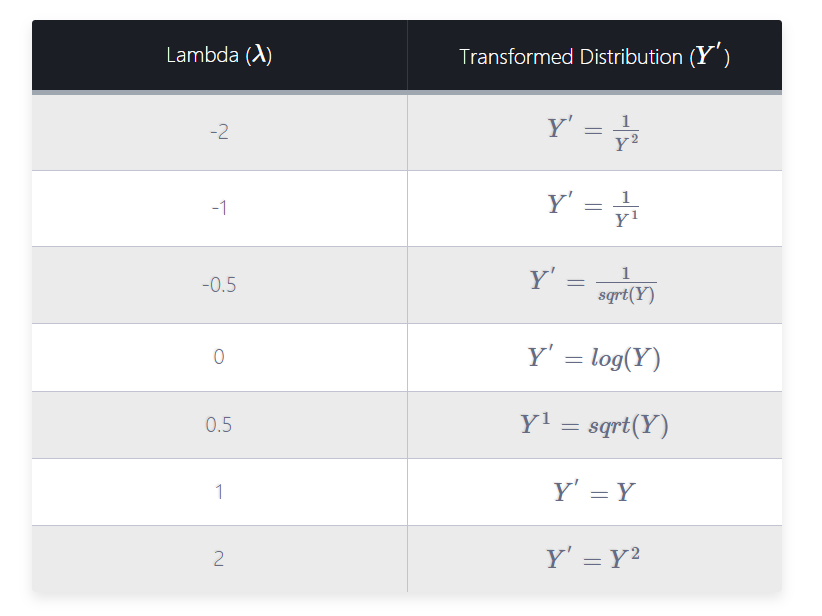

In [ ]:
# Select the ones you want
tsb = df[['VALUE_CLEAN']].copy()
transbox =tsb.values.flatten()


In [ ]:
print(type(transbox))

In [ ]:
transform = boxcox(transbox, 0)

In [ ]:
transform

In [ ]:
# Before!
sns.displot(transbox, kind="kde")

In [ ]:
# After!
sns.displot(transform, kind="kde")

# Transform to Normal Distribution

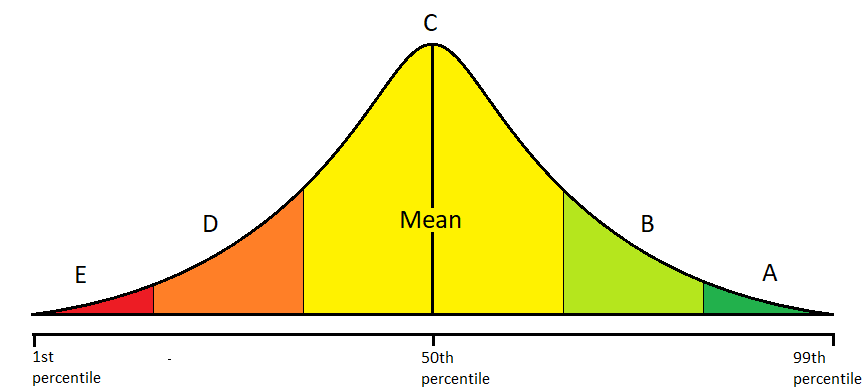

https://aegis4048.github.io/transforming-non-normal-distribution-to-normal-distribution

In [ ]:
# fit lognormal distribution
shape, loc, scale = stats.lognorm.fit(transbox, loc=0)
pdf_lognorm = stats.lognorm.pdf(transbox, shape, loc, scale)

# fit normal distribution
mean, std = stats.norm.fit(transbox, loc=0)
pdf_norm = stats.norm.pdf(transbox, mean, std)

# fit weibull distribution
shape, loc, scale = stats.weibull_min.fit(transbox, loc=0)
pdf_weibull_min = stats.weibull_min.pdf(transbox, shape, loc, scale)

In [ ]:
pdf_lognorm

In [ ]:
sns.displot(pdf_lognorm, kind="kde")

# Q-Q Plots

Visual inspection can be done in a different way with Q-Q plots. The red straight line is the fitted theoretical Gaussian distribution function. If the scatter plot is closer to the red straight line, it means that the data is very close to Gaussian distribution. Deviation from the red line indicates that the data is most likely not Gaussian.

In [ ]:
# Random data points generated
data_points = np.random.normal(0, 1, 100)    
  
sm.qqplot(data_points, line ='45')
py.show()